# Using sklearn’s Random Forest classifier to determine player roles in soccer

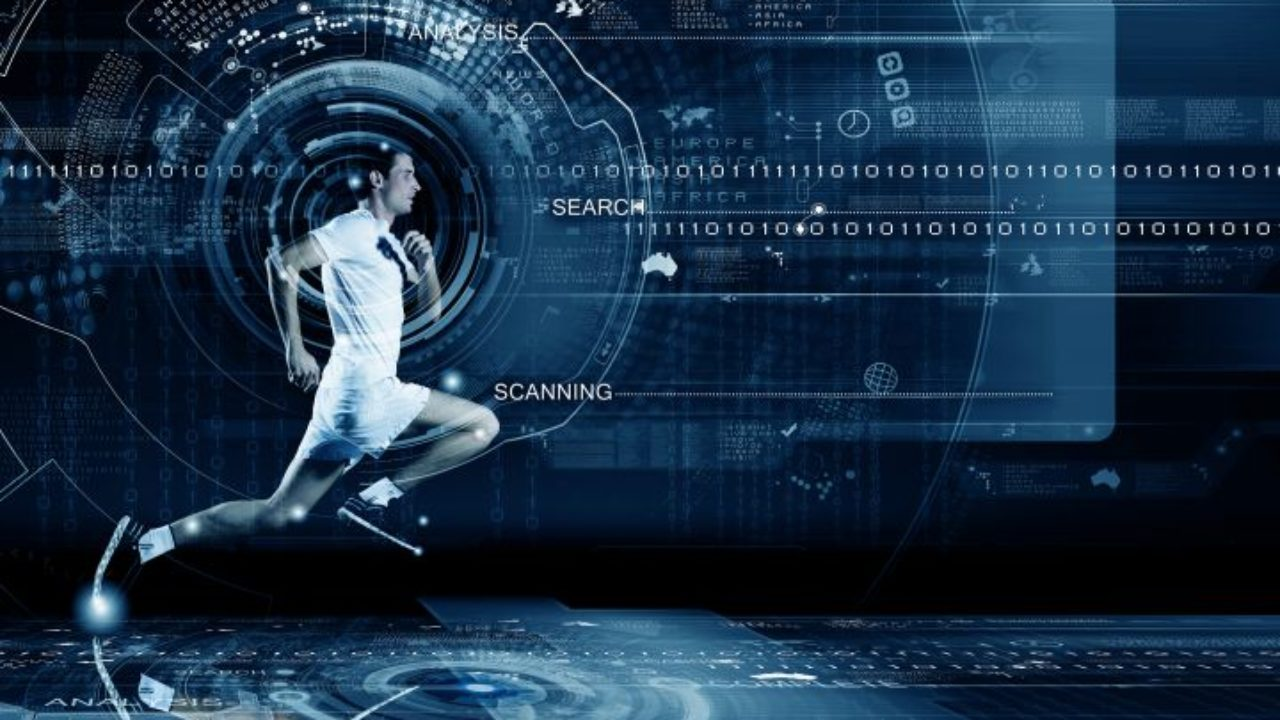

In [9]:
from IPython.display import Image 
sports_data = Image(filename='sports_data.jpg', width = 500)
display(sports_data)

### > Sample live query, any player/latest match

In [15]:
import pandas as pd
from sqlalchemy import create_engine
from settings1 import postgres_str
from datetime import datetime

cnx = create_engine(postgres_str)

# try L. Messi from Barcelona, Cristiano Ronaldo from Juventus, K. Mbappé from PSG
shortName = "Cristiano Ronaldo"
sample_live_query = f'''WITH input_name AS (SELECT "playerId" FROM all_players WHERE "shortName"='{shortName}')
                        SELECT * from advanced_stats_total WHERE "playerId" IN 
                        (SELECT "playerId" FROM input_name) ORDER BY "dateutc" DESC LIMIT 1''' 
print(f'start query {datetime.now().strftime("%X")}')
sample_live = pd.read_sql(sample_live_query, cnx)
print(f'end query {datetime.now().strftime("%X")}')
sample_live.head()

start query 05:26:54
end query 05:26:59


,matches,matchesInStart,matchesSubstituted,matchesComingOff,minutesOnField,minutesTagged,goals,assists,shots,headShots,...,matchId,playerId,competitionId,label,date,dateutc,status,seasonId,roundId,gameweek
0,1,1,0,0,96,96,1,0,7,2,...,5154440,3322,524,"Juventus - Spezia, 3-0",2021-03-02 20:45:00,2021-03-02,Played,186353,4422711,25


### > EDA (prepped_df local load)

In [16]:
import numpy as np
import pandas as pd
from pandas_profiling import ProfileReport

In [65]:
prepped_df = pd.read_csv('prepped_df.csv')
prepped_df.sample(3)

,playerId,matchId,teamId,minutesTagged,shots,headShots,linkupPlays,duels,defensiveDuels,offensiveDuels,...,form_4_5_1_1,form_5_3_0_0,form_5_3_0_1,form_5_3_1_0,form_5_3_1_1,form_5_3_2_0,form_5_3_2_1,form_5_4_1_0,form_5_4_1_1,role
985,8246,2823197,1610,79,2.113231,0.0,0.0,16.905847,5.283077,7.396308,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,box_to_box
226,51202,2809798,6739,94,0.981115,0.0,0.0,17.660064,10.792261,4.905573,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,regista
829,344864,2829903,1631,96,0.971971,0.0,0.0,13.607598,1.943943,0.971971,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,agg_cb


In [35]:
prepped_df.shape

(23988, 286)

In [38]:
profile = ProfileReport(prepped_df, title='Pandas Profiling Report', minimal=True)

### > Pandas_Profiling

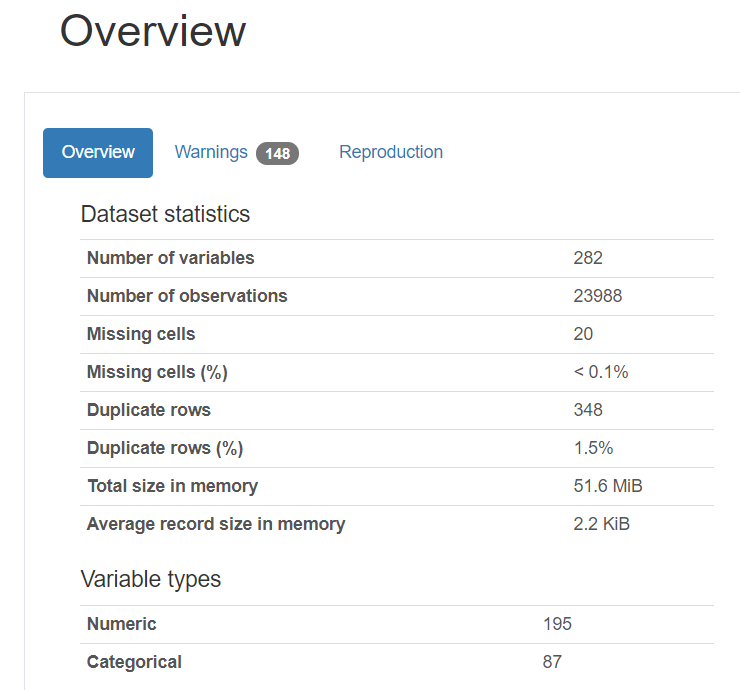

...


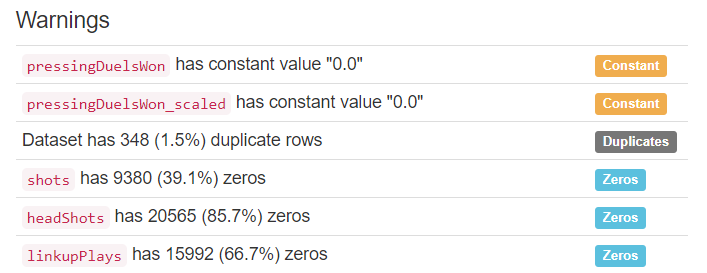

...


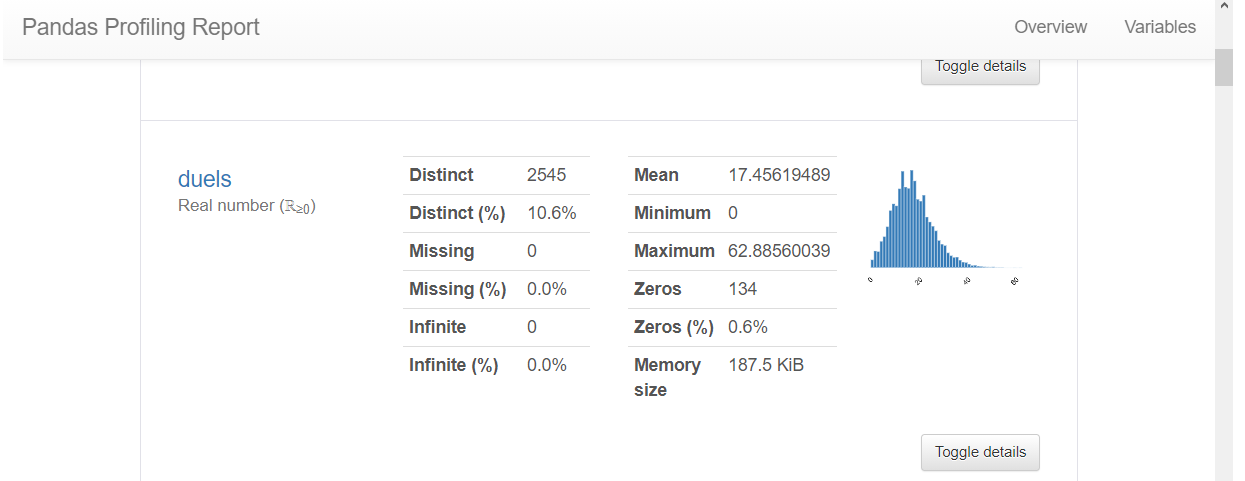

...


In [39]:
from IPython.display import Image 

for img_name in ['profiling2.png','profiling3.png','profiling.png']:
    img = Image(filename=img_name, width = 600)
    display(img)
    print('...')

#### > Correlations

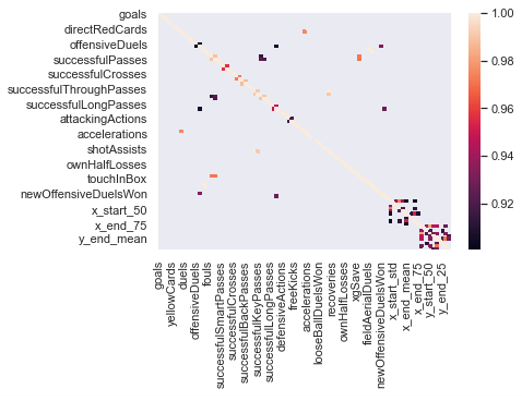

In [303]:
corr = Image(filename='corr.png', width = 500)
display(corr)

#### > Removing Outliers based on IQR

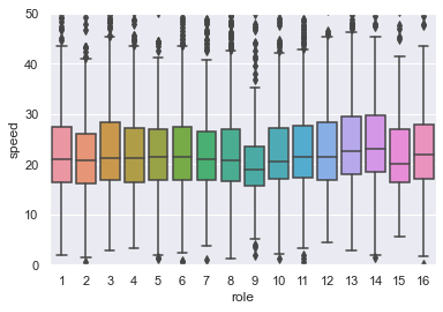

In [314]:
bars = Image(filename='bars.png', width = 400)
display(bars)

### > Class with model, CV, GS, Results

In [313]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import LeaveOneGroupOut, RandomizedSearchCV, GroupKFold

class RFC:
    '''example train and test of prepped_df to demonstrate part of ML pipeline'''
    
    def __init__(self, df):
        self.df = df[df.minutesTagged >= 18]
        self.df = self.df[self.df.role.isin(['tank','classic_winger','fb'])]
        self.X = None
        self.y = None
    
    def makeDicts(self):
        for index, dtype in enumerate(self.df.dtypes):
            if dtype == 'int64':
                self.df[f'{self.df.columns[index]}'] = pd.to_numeric(self.df[f'{self.df.columns[index]}'], downcast='integer')
            elif dtype == 'float64':
                self.df[f'{self.df.columns[index]}'] = pd.to_numeric(self.df[f'{self.df.columns[index]}'], downcast='float')
        # id_role_dict is 'playerId: role'
        self.id_role_series = pd.Series(self.df['role'].values,index=self.df['playerId'])
        self.id_roles, self.id_roles_num, self.id_roles_num_equiv = [], [], []
        self.id_role_dict_num = {}
        self.id_roles = self.df.role.unique()
        for role in range(len(self.id_roles)):
            self.id_roles_num.append(role+1)
        # id_roles_num_equiv is 'role: role_numerical'
        self.id_roles_num_equiv = pd.Series(self.id_roles_num, index=self.id_roles).transpose().to_dict()
        # id_role_dict_num is 'playerId: role_numerical'
        self.id_role_dict_num = self.id_role_series.map(self.id_roles_num_equiv).to_dict()
        
    def makeXYGroups(self):
        self.df.columns = [x.replace(']', '))').replace('[', '((') for x in self.df.columns]
        self.df =  self.df.dropna()
        self.X = self.df.copy()
        y_string = self.X.pop('role')
        self.X = self.X.drop(columns=['matchId', 'teamId', 'minutesTagged'])
        self.groups = self.X.pop('playerId')
        self.y = y_string.map(self.id_roles_num_equiv)
        
    def makeModel(self):
         self.model = RandomForestClassifier(n_estimators=800,random_state=0, n_jobs=-1)
    
    def makeLogo(self):
        logo = LeaveOneGroupOut()
        self.y_true, self.y_pred, self.playerIdList = list(), list(), list()
        count = 0
        totalPlayers = len(self.df.role.unique())
        for train_ix, test_ix in logo.split(self.X, self.y, self.groups):
            X_train, X_test = self.X.iloc[train_ix], self.X.iloc[test_ix]
            y_train, y_test = self.y.iloc[train_ix], self.y.iloc[test_ix]
            print(f'fit {datetime.now().strftime("%X")}')
            self.model.fit(X_train, y_train)
            print(f'predict {datetime.now().strftime("%X")}')
            yhat = self.model.predict(X_test)
            self.y_true.append(np.array(y_test))
            self.y_pred.append(yhat)
            self.playerIdList.append(self.df.playerId.iloc[test_ix[0]])
            count += 1
            print(f'done with playerId: {self.df.playerId.iloc[test_ix[0]]}, {count}/{4}') #prints playerId
        return self.model
    
    def formatResults(self):
        id_roles_num_equiv_rev = {v: k for k, v in self.id_roles_num_equiv.items()}
        cv_mat = pd.DataFrame()
        cv_mat['playerId'] = self.playerIdList
        actualRole = list()
        for player in self.playerIdList:
            actualRole.append(id_roles_num_equiv_rev[self.id_role_dict_num[player]])
        cv_mat['actual'] = actualRole
        cv_mat['1st-prob'] = np.linspace(np.nan,np.nan,len(cv_mat['actual']))
        cv_mat['2nd-prob'] = np.linspace(np.nan,np.nan,len(cv_mat['actual']))
        cv_mat['match'] = np.linspace(np.nan,np.nan,len(cv_mat['actual']))

        for ix, player in enumerate(list(cv_mat.playerId)):
            for role in self.id_roles_num:
                cv_mat.loc[ix, f'{id_roles_num_equiv_rev[role]}'] = np.mean(self.y_pred[ix] == role)
                    
        for i in range(len(self.playerIdList)):
            cv_mat.loc[i, '1st-prob'] =  cv_mat.iloc[i,5:].astype('float').nlargest(2).index[0]
            cv_mat.loc[i, '2nd-prob'] = cv_mat.iloc[i,5:].astype('float').nlargest(2).index[1]

        cv_mat['match'] = np.where((cv_mat['1st-prob'] == cv_mat['actual']) | (cv_mat['2nd-prob'] == cv_mat['actual']), 1, 0)
        total_accuracy = sum(cv_mat.match)/len(cv_mat.match)
        print(f'Efficiency: {total_accuracy}')
        return cv_mat
    
    def randGridSearch(self):
        param_dist_dict = { #"n_estimators": list(np.arange(600,1000,100)),
                            #"max_features": ['log2', 'sqrt'],
                            "max_depth": list(np.arange(20,30,5)),
                            #'min_samples_leaf': list(np.arange(10,200,20)),
                            'min_samples_split': list(np.arange(400,500,50))
                            #'bootstrap': [True, False]
                         }
        print(f'start RandomSearchCV {datetime.now().strftime("%X")}')
        gkf = GroupKFold(n_splits=3)
        rf_random = RandomizedSearchCV(estimator = self.model, param_distributions = param_dist_dict, n_iter = 500, cv = gkf, verbose=2, random_state=42, n_jobs = -1)
        rf_random.fit(self.X, self.y, groups=self.groups)
        print(rf_random.best_params_)
        rf_best = pd.DataFrame.from_dict(data=rf_random.best_params_, orient='index')
        rf_best['params'] = rf_best.index
        rf_pd = pd.DataFrame.from_dict(data=rf_random.cv_results_, orient='index')
        rf_pd['params'] = rf_pd.index
        return rf_random.best_params_, rf_random.cv_results_
    
random_forest = RFC(prepped_df)

In [307]:
# builds model from class
random_forest.makeDicts()
random_forest.makeXYGroups()
random_forest.makeModel()

### > LOGO Cross-Validation

In [308]:
# LOGO CV
model = random_forest.makeLogo()

fit 08:50:00
predict 08:50:01
done with playerId: 14869, 1/4
fit 08:50:01
predict 08:50:02
done with playerId: 68081, 2/4
fit 08:50:02
predict 08:50:03
done with playerId: 233586, 3/4
fit 08:50:03
predict 08:50:04
done with playerId: 444359, 4/4


### > Sample Results

In [309]:
out_df = random_forest.formatResults()
out_df

Efficiency: 0.5


,playerId,actual,1st-prob,2nd-prob,match,tank,classic_winger,fb
0,14869,fb,classic_winger,tank,0,0.087719,0.912281,0.00
1,68081,classic_winger,fb,tank,0,0.250000,0.000000,0.75
2,233586,tank,tank,classic_winger,1,1.000000,0.000000,0.00
3,444359,tank,tank,classic_winger,1,0.965517,0.034483,0.00


### > Typical Results

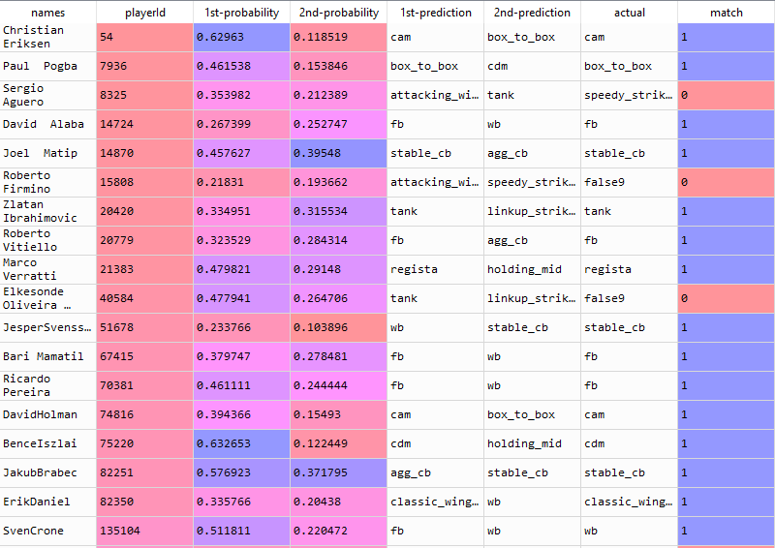

In [310]:
typ_results = Image(filename='results.png', width = 700)
display(typ_results)

### > Randomized Gridsearch

In [311]:
# Randomized GridSearch
rgs = random_forest.randGridSearch()

start RandomSearchCV 08:50:12
Fitting 3 folds for each of 4 candidates, totalling 12 fits


C:\Users\kmsli\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:278: UserWarning: The total space of parameters 4 is smaller than n_iter=500. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  12 | elapsed:    4.0s remaining:   12.1s
[Parallel(n_jobs=-1)]: Done  10 out of  12 | elapsed:    4.0s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    4.1s finished


{'min_samples_split': 400, 'max_depth': 20}


### > Feature Importance 

Index(['x_start_0.1_quantile', 'x_start_0.5_quantile', 'x_start_0.8_quantile',
       'x_start_0.2_quantile', 'x_start_0.9_quantile', 'y_start_0.1_quantile',
       'y_start_0.5_quantile', 'y_start_0.8_quantile', 'y_start_0.2_quantile',
       'y_start_0.9_quantile', 'x_end_0.1_quantile', 'x_end_0.5_quantile',
       'x_end_0.8_quantile', 'x_end_0.2_quantile', 'x_end_0.9_quantile',
       'y_end_0.1_quantile', 'y_end_0.5_quantile', 'y_end_0.8_quantile',
       'y_end_0.2_quantile', 'y_end_0.9_quantile', 'weight_(40, 68))',
       'weight_(68, 72))', 'weight_(72, 76))', 'weight_(76, 80))',
       'weight_(80, 120))', 'weight_nan', 'height_(130, 174))',
       'height_(174, 178))', 'height_(178, 182))', 'height_(182, 186))'],
      dtype='object')


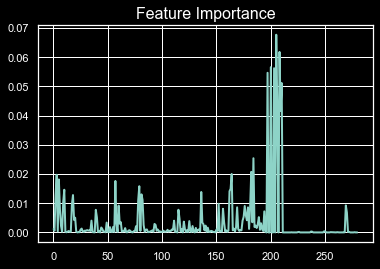

In [296]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use("dark_background")
plt.plot(model.feature_importances_)
plt.title('Feature Importance')
print(prepped_df.columns[180:210])

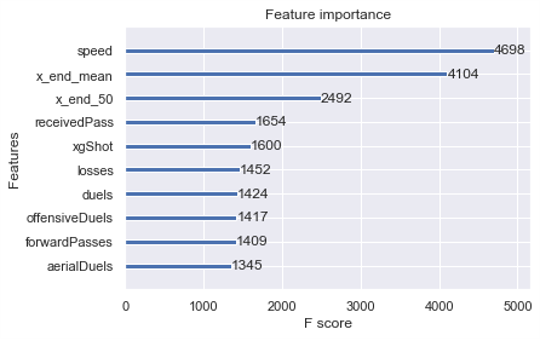

In [324]:
feat_imp = Image(filename='feat_imp.png', width = 400)
display(feat_imp)

### SHAP Model Explainability

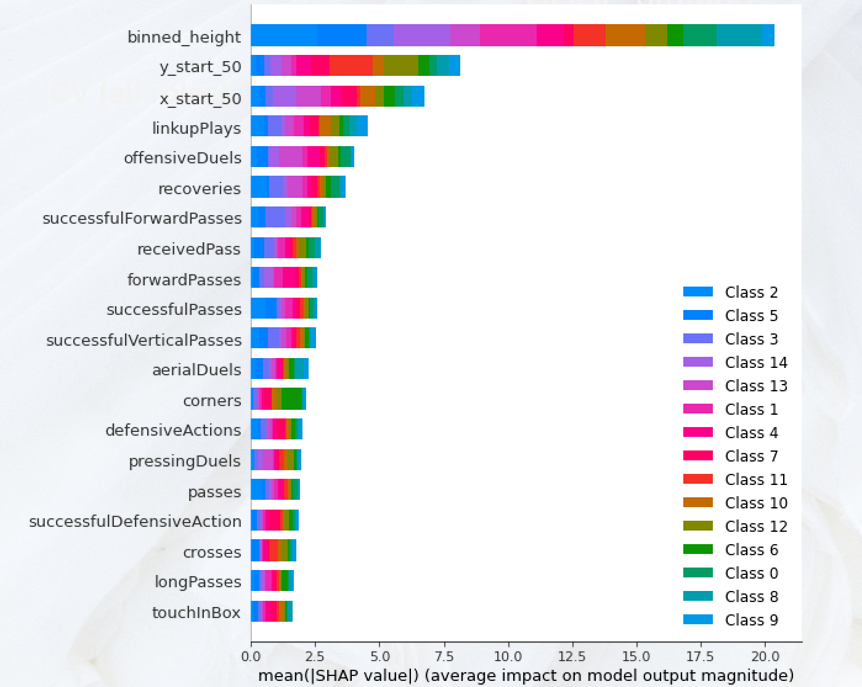

...


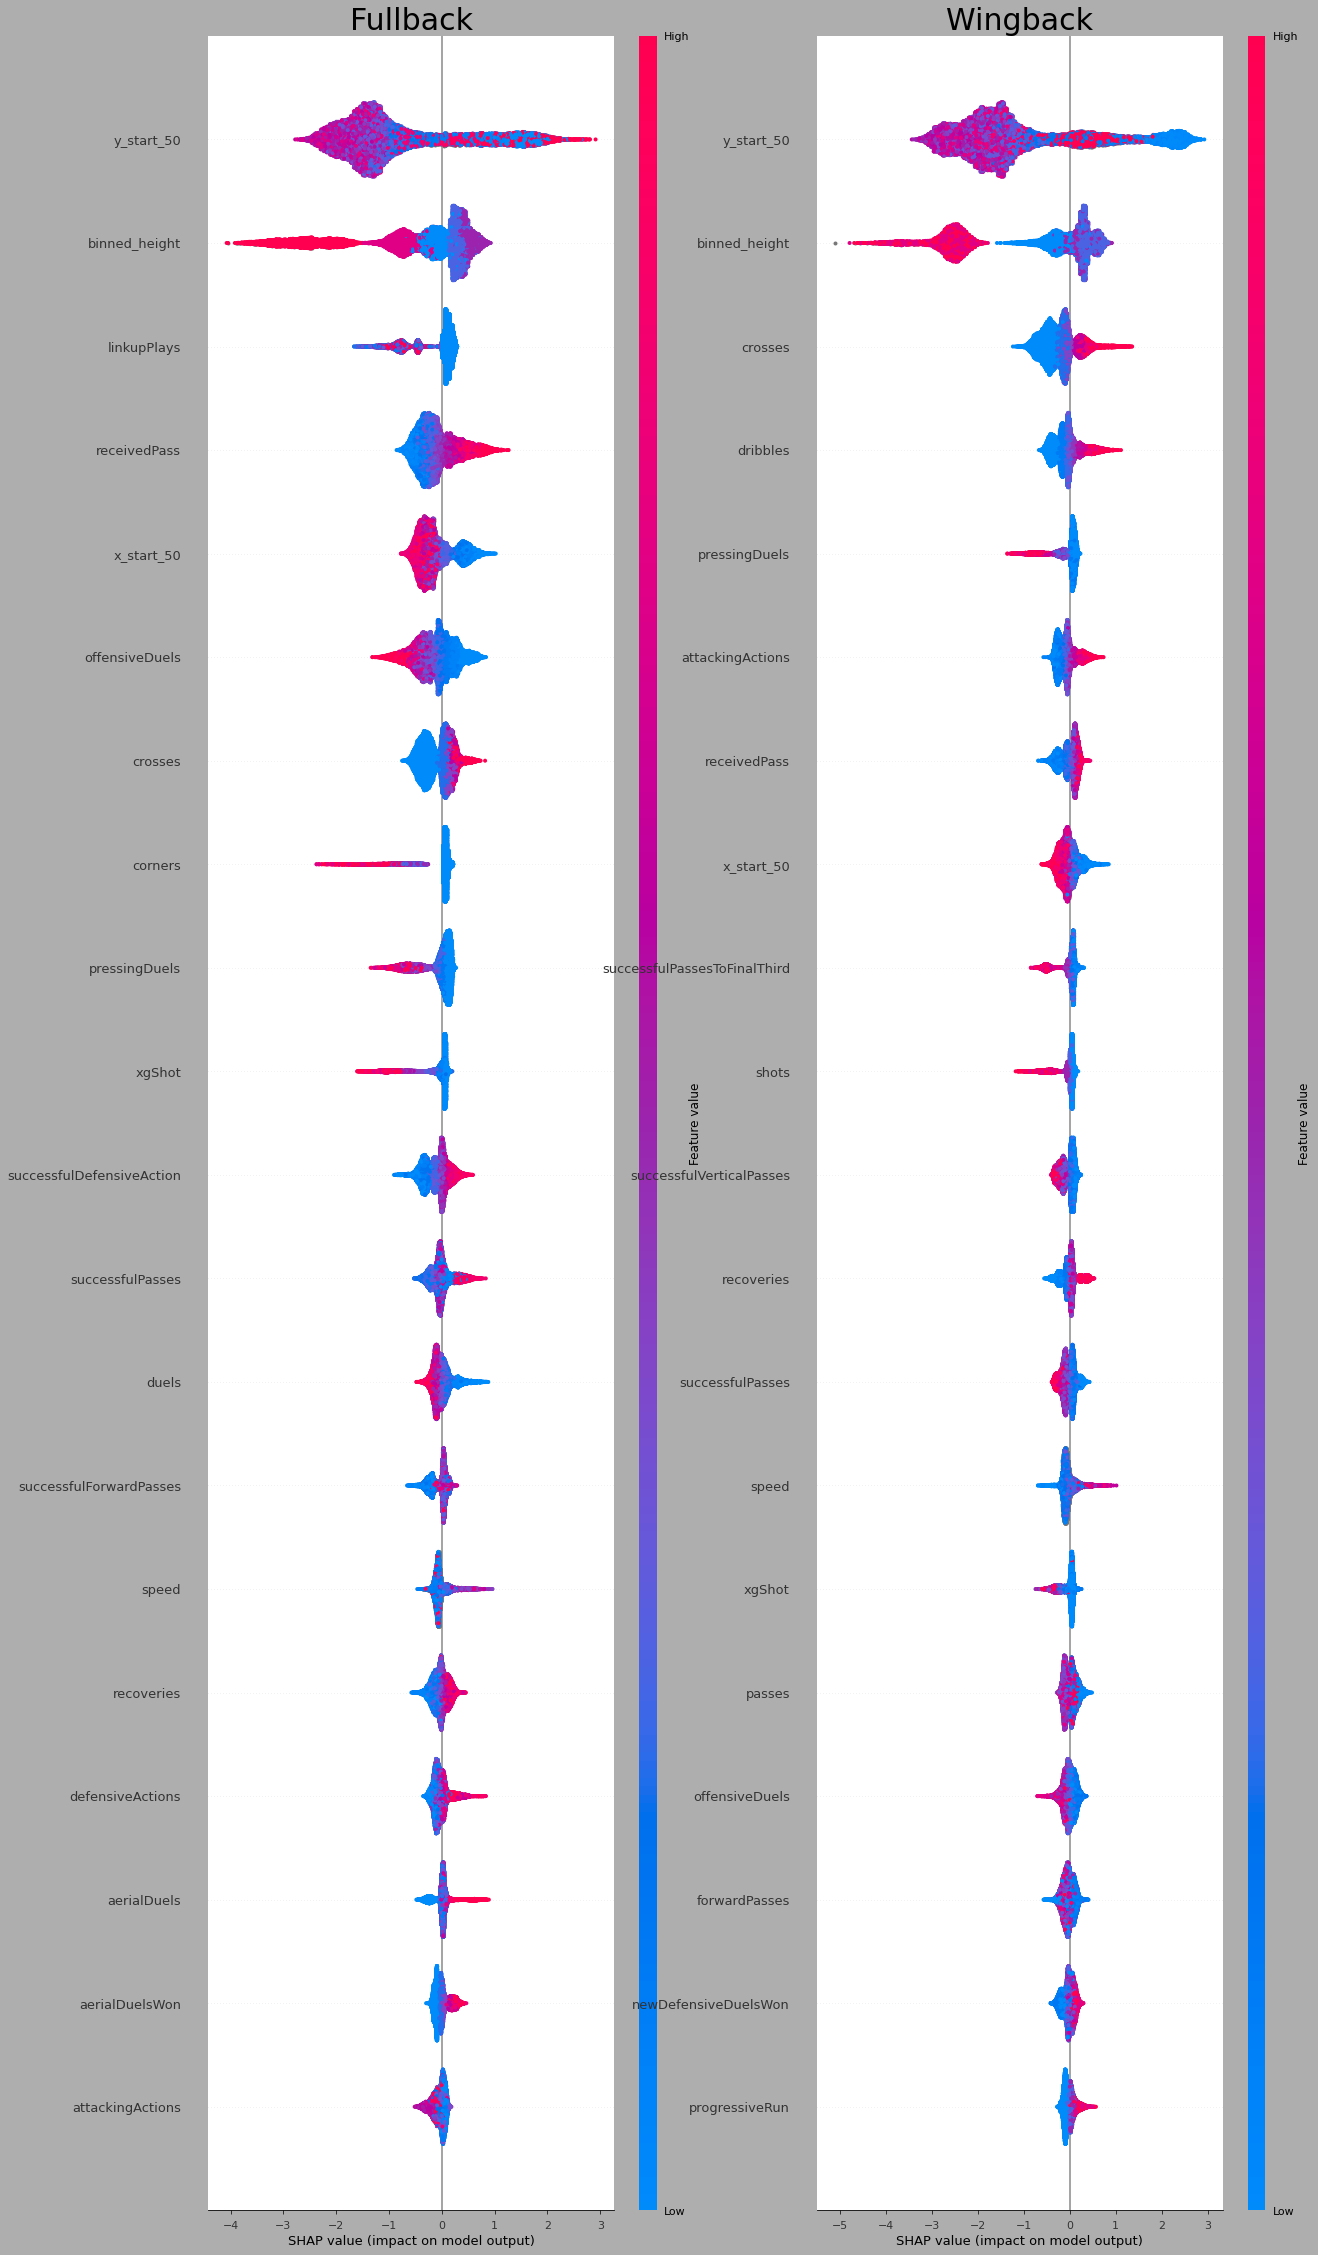

...


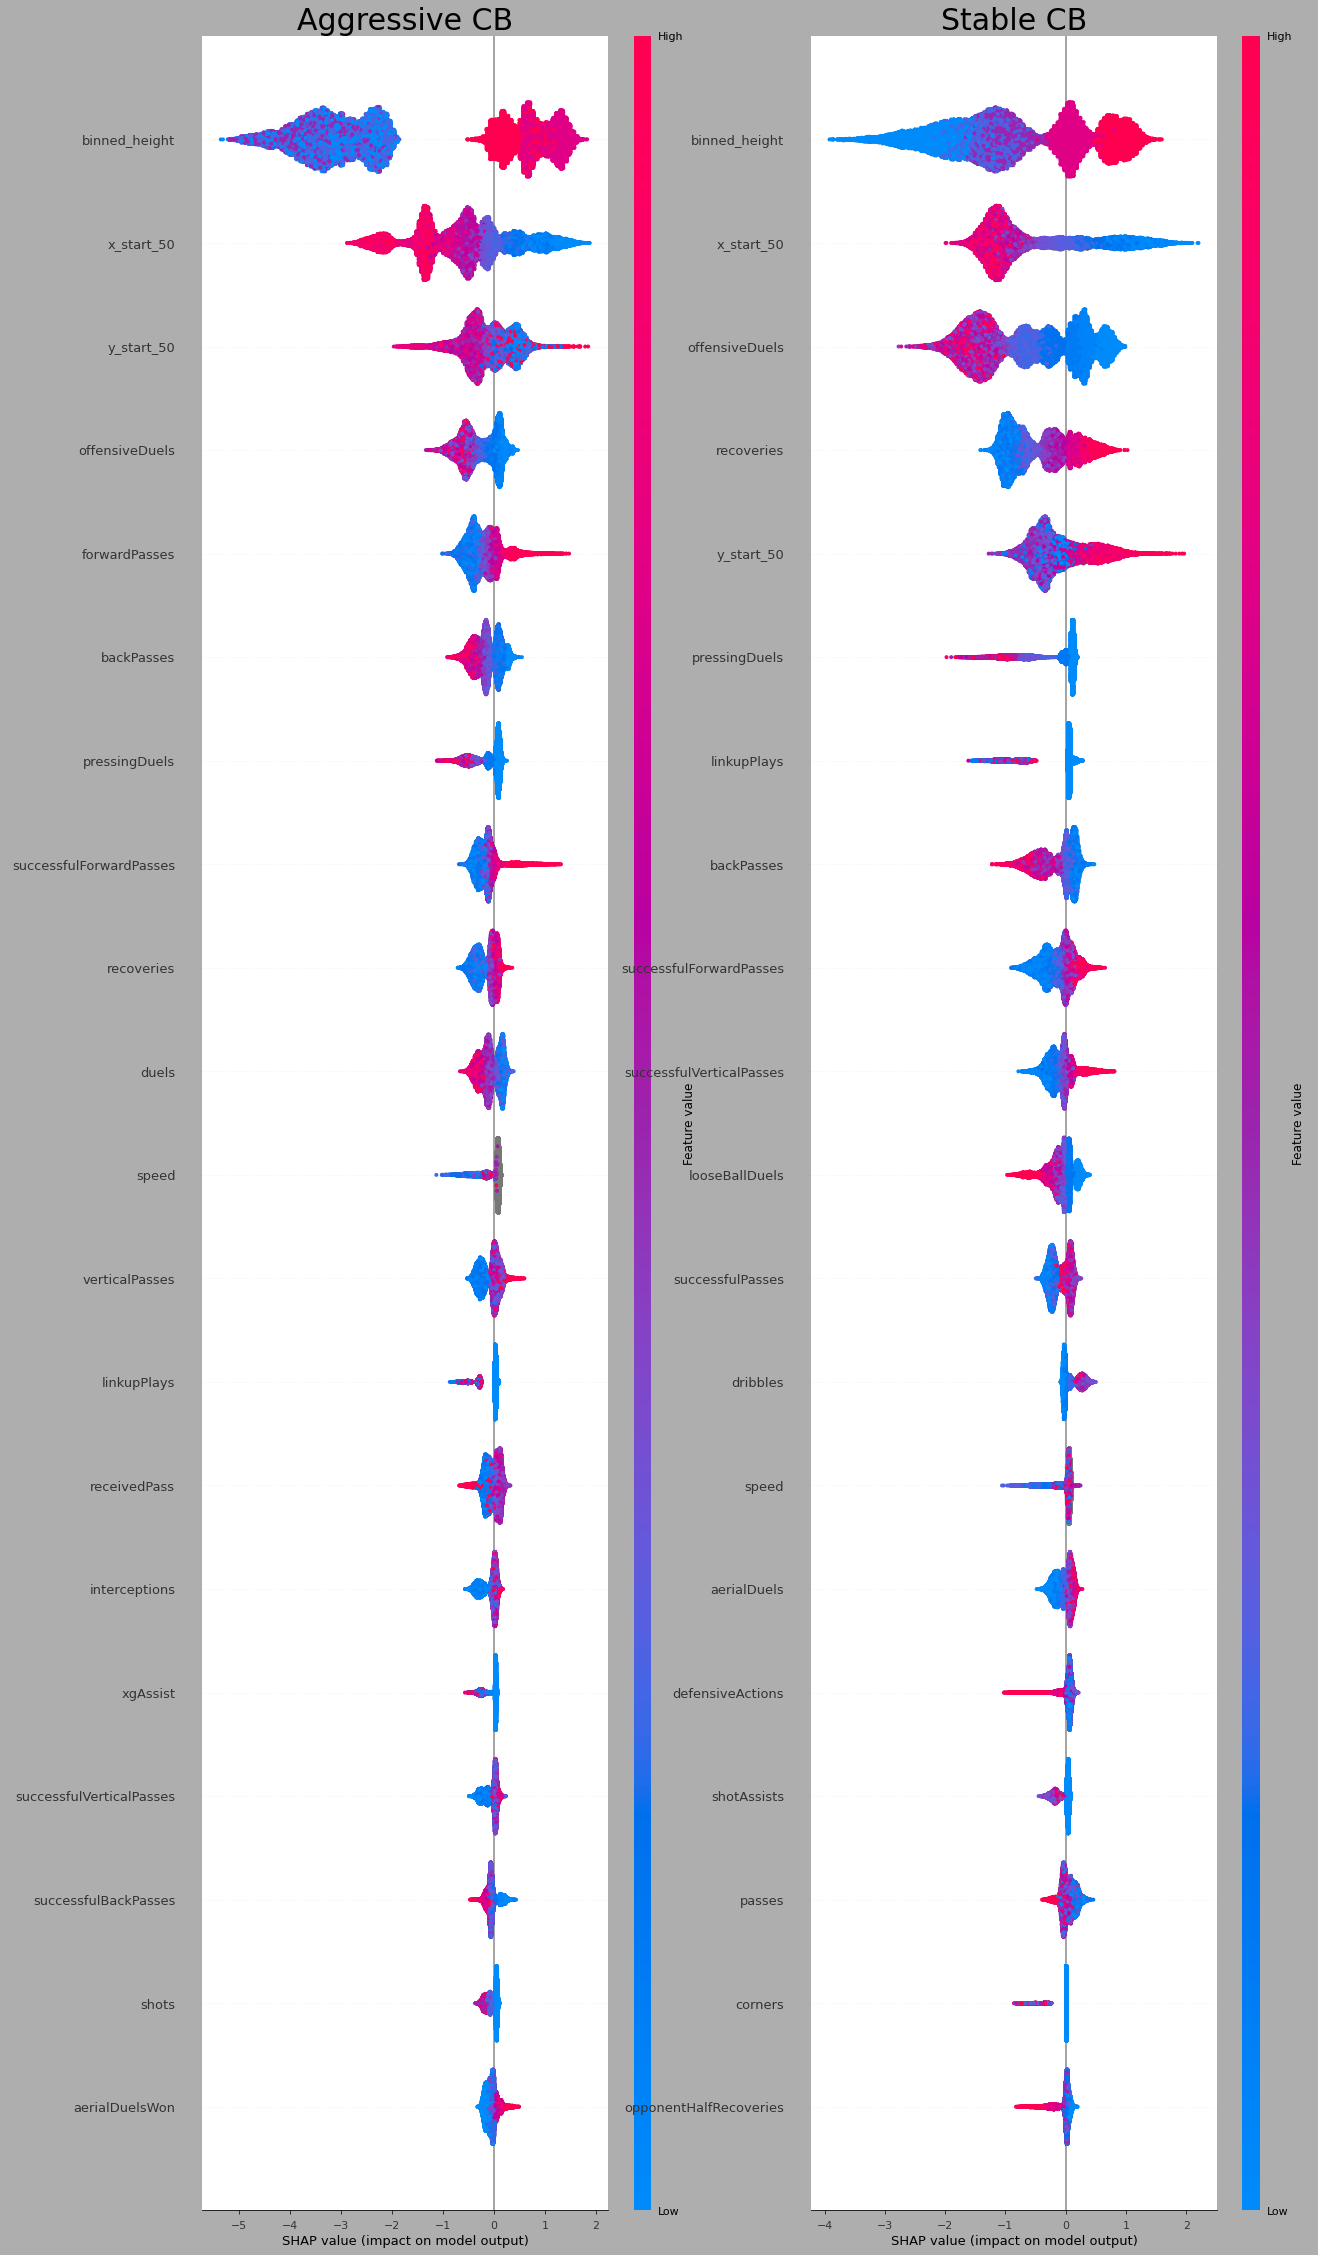

...


In [325]:
for img_id in ['shap1.png','shap2.png','shap3.png']:
    img = Image(filename=img_id, width = 600)
    display(img)
    print('...')